## Movie Recommender with TFIDF movie scores and User Profiles

In this exercise we will create top recommendations for users based on their already rated movies. We will use the tags as the features for a movie. These tages will be used to create a profile of movies and a profile of users.

The datasets available for this exercise is as follows:

 - **movies**  : This dataset has the movieId and the name and details of all the movies in the database.
 - **ratings** : This dataset has the ratings given by each userId to the movieId they have seen.
 - **tags**    : This dataset has the tags given by each userId to the movieId they have seen.

### The idea behind recommending movies to user based on their already rated movies is as follows :

 - **Step 1.** Create a TF-IDF vector for each movie. This will be based on the tags a movie gets. Here the tags a movie gets act as a text for this movie. So, basically count of tags a movie gets compared to how common this tag is in overall universe. This creates a feature dimension for every movie.
 - **Step 2.** Create every user's profile based on how they rated their movies. Every movie has a TFIDF vector based on tags (or a feature dimension) and the ratings given by user to a movie creates a weight for each of this dimension for that user. So now based on all the movies a user rated, the user will have one overall profile.
 - **Step 3.** Now use the profile of the user to find movies which have simlar tags to user's profile (using cosine similarity).
 - **Step 4.** Recommend top movies most similar to user profile which the user has not seen or rated.

In [1]:
# import key libraries

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import gc
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity as cs
from sklearn.metrics.pairwise import euclidean_distances as ed
from wordcloud import WordCloud

%matplotlib inline

sns.set(style='darkgrid')
sns.set(font_scale=1.5)

# import datasets

movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')
tags = pd.read_csv('tags.csv')
tags['tag'] = tags['tag'].str.lower()

In [2]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
ratings.head()

,userId,movieId,rating,timestamp
0,12882,1,4.0,1147195252
1,12882,32,3.5,1147195307
2,12882,47,5.0,1147195343
3,12882,50,5.0,1147185499
4,12882,110,4.5,1147195239


In [4]:
tags.head()

,movieId,userId,tag,timestamp
0,3916,12882,sports,1147195545
1,4085,12882,eddie murphy,1147195966
2,33660,12882,boxing,1147195514
3,1197,320,must show,1145964801
4,1396,320,must show,1145964810


In [5]:
# Get basic information about the datasets

print movies.shape, ratings.shape, tags.shape
print 'Unique movies : ', movies['movieId'].nunique()
print 'Unique users in ratings data : ', ratings['userId'].nunique()
print 'Unique movies in ratings data : ', ratings['movieId'].nunique()
print 'Unique movies in tags data : ', tags['movieId'].nunique()
print 'Unique users in tags data : ', tags['userId'].nunique()
print 'Unique tags in tags data : ', tags['tag'].nunique()

(2500, 3) (264505, 4) (94875, 4)
Unique movies :  2500
Unique users in ratings data :  862
Unique movies in ratings data :  2500
Unique movies in tags data :  2495
Unique users in tags data :  862
Unique tags in tags data :  12145


### Some basic data visualization

Looking at the average ratings for the movies and the most popular tags used by the users.

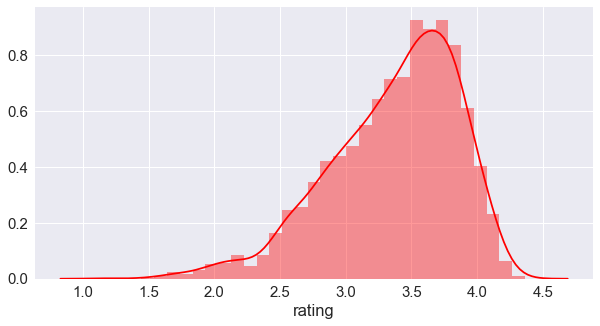

In [7]:
# Average ratings across all movies
mv_rating = ratings.groupby(by='movieId',as_index=False).agg({'rating':'mean'}).reset_index(drop=True)
f, ax = plt.subplots(figsize = (10,5))
sns.distplot(mv_rating['rating'], color='red')

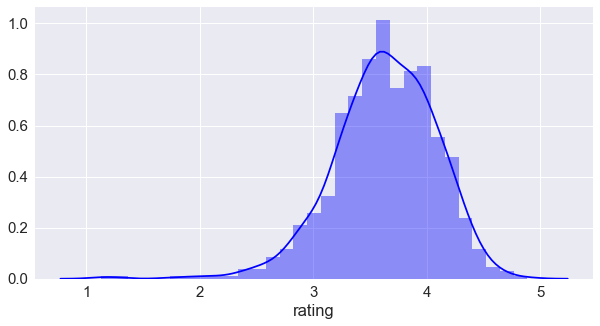

In [8]:
# Average ratings across all users
user_rating = ratings.groupby(by='userId',as_index=False).agg({'rating':'mean'}).reset_index(drop=True)
f, ax = plt.subplots(figsize = (10,5))
sns.distplot(user_rating['rating'], color='blue')

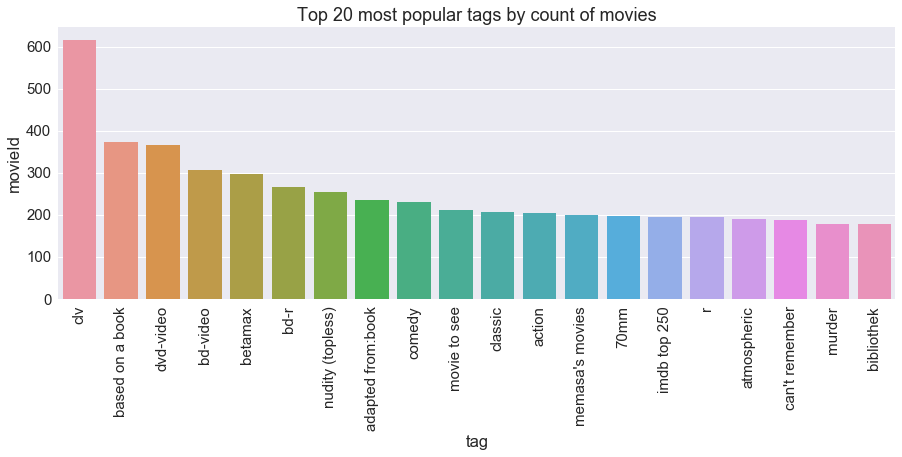

In [9]:
# most popular tags in tags dataset - count of unique movies for each tag
tag_count = tags.groupby(by='tag',as_index=False).agg({'movieId':'nunique'}).reset_index(drop=True)
tag_count = tag_count.sort_values(by='movieId', ascending=False).reset_index(drop=True)
tag_count['tag'] = tag_count['tag'].str.lower()
f, ax = plt.subplots(figsize = (15,5))
bp = sns.barplot(x='tag', y='movieId', data=tag_count.iloc[0:20,:])
bp.set_xticklabels(bp.get_xticklabels(), rotation = 90)
bp.set_title('Top 20 most popular tags by count of movies')

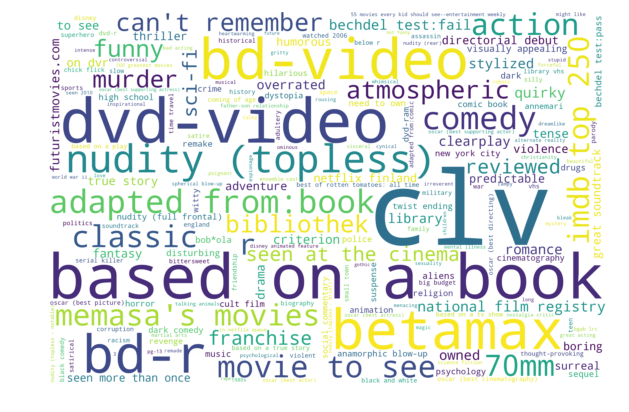

Time to generate the wordcloud :  18.7 secs


In [10]:
# generate a wordcloud of most popular tags

# wordcloud takes two inputs - a string with repeated words or a dictionary with word frequencies
# we will create a dictionary as we already have a word frequency in table

st = time.time()

d={}
for i,row in tag_count.iterrows():
    d[row['tag']] = row['movieId']

wc = WordCloud(width=3000, height=2000, background_color='white').generate_from_frequencies(d)
fig = plt.figure(figsize = (10, 8))
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

et = time.time()

print "Time to generate the wordcloud : ", round(et - st,1), "secs"

### Step 1. TFIDF vector for each movie
#### Term Frequency (TF)

Consider each movie like a document and then each tag as words in the document. Counting the number of times each tags occur (given by any user) will give us the tag frequency. In our case this will be the count of users who gave this tag to this movie. Dividing this frequency with the total count of all tags for this movie (size of document) will give us "TERM FREQ" for this tag.

So for a movie i and tag t, the term freq TF is:

\begin{equation*}
TF_{ti} = \frac{n}{N}
\end{equation*}

where,
 - **n** = unique count of users who gave this tag to this movie
 - **N** = count of all tags for this movie

#### Inverse Document Frequency (IDF)

In our case the word vocabulary universe is the total unique tags that appear in all movies (12,145). Document frequency for each of the words (tags in our case) will be the count of movies each tag has been assigned to, so we know how common this word (tag) is across all documents (movies in our case). Inverse document frequency is then inverse of this. We also apply log to this as the scale becomes very small.

So IDF for tag t is:

\begin{equation*}
IDF(t) = log(\frac{D}{d})
\end{equation*}

where,
 - **D** = total number of movies in universe
 - **d** = number of movies where this tag T appears

#### TFIDF score

The TFIDF score for a tag for a given movie is the multiplication of above two factors. 

\begin{equation*}
TS_{ti} = TF_{ti} \times IDF(t)
\end{equation*}

where,
 - **$TS_{ti}$** is the final TFIDF score for a tag t for movie i

In [11]:
# Get the inverse document frequency for every tag - 1 global vector for every tag

df = tags.groupby(by=['tag'], as_index=False).agg({'movieId':'nunique'}).reset_index(drop=True)
df = df.sort_values(by='movieId', ascending=False).reset_index(drop=True)
df = df.rename(columns={'movieId' : 'doc_freq'})
df['doc_count'] = movies['movieId'].nunique()
df['IDF'] = np.log(1.0*df['doc_count']/df['doc_freq'])

# get the term frequency for every tag in every movie

mv_tf = tags.groupby(by=['movieId', 'tag'], as_index=False).agg({'userId':'nunique'}).reset_index(drop=True)
mv_tf = mv_tf.sort_values(by=['movieId', 'userId'], ascending=[True, False]).reset_index(drop=True)
mv_tf = mv_tf.rename(columns={'userId' : 'tag_count'})

mv_size = tags.groupby(by='movieId', as_index=False).agg({'userId' : 'count'}).reset_index(drop=True)
mv_size = mv_size.sort_values(by=['userId'], ascending=False).reset_index(drop=True)
mv_size = mv_size.rename(columns={'userId' : 'all_tag_count'})

mv_tf = mv_tf.merge(mv_size, on='movieId', how='inner')
mv_tf['TF'] = 1.0*mv_tf['tag_count']/mv_tf['all_tag_count']

# combine two datasets to get the TFIDF score of every movie tag

mv_tf = mv_tf.merge(df, on='tag', how='outer')
mv_tf['TFIDF'] = mv_tf['TF'] * mv_tf['IDF']

mv_tf.head()

,movieId,tag,tag_count,all_tag_count,TF,doc_freq,doc_count,IDF,TFIDF
0,1,pixar,22,105,0.209524,25,2500,4.60517,0.964893
1,596,pixar,1,35,0.028571,25,2500,4.60517,0.131576
2,2294,pixar,3,27,0.111111,25,2500,4.60517,0.511686
3,2355,pixar,8,39,0.205128,25,2500,4.60517,0.944650
4,3114,pixar,11,63,0.174603,25,2500,4.60517,0.804077


In [12]:
# checking the TFIDF scores of a particular movie
mv_tf[mv_tf['movieId'] == 2231]

,movieId,tag,tag_count,all_tag_count,TF,doc_freq,doc_count,IDF,TFIDF
11603,2231,2.5,1,32,0.03125,36,2500,4.240527,0.132516
12782,2231,library vhs,1,32,0.03125,57,2500,3.780995,0.118156
20144,2231,john malkovich,3,32,0.09375,17,2500,4.990833,0.467891
29497,2231,john turturro,3,32,0.09375,11,2500,5.426151,0.508702
31550,2231,gambling,3,32,0.09375,15,2500,5.115996,0.479625
31873,2231,poker,6,32,0.18750,5,2500,6.214608,1.165239
31977,2231,john dahl,1,32,0.03125,2,2500,7.130899,0.222841
35509,2231,edward norton,7,32,0.21875,18,2500,4.933674,1.079241
38782,2231,cards,1,32,0.03125,3,2500,6.725434,0.210170
42236,2231,watched 2006,1,32,0.03125,55,2500,3.816713,0.119272


### Step 2. Build user profile

Every user has given movies they have seen some rating. Every movie also has some tags associated with them. Every tag has a TFIDF vector we calculated above. Now user profile can be built in two ways - 

#### 1. Unweighted User Profile:

For this process, we will look at movies the user has really liked (>=3.5 rating) and create a user + tag level score vector from these movies. The vector will be basically sum of the TFIDF score created for these tags.

\begin{equation*}
P_{ut}(UW) = \sum_{M_{u} >= 3.5} TS_{ti} 
\end{equation*}

where
 - **$P_{ut}(UW)$** is the Unweighted user profile vector term for tag t.
 - **$M_{u}$** are all the Movies rated >= 3.5 by the user
 - **$TS_{ti}$** is the TFIDF vector for tag t for all the movies $M_u$
 

#### 2. Weighted User Profile: 

For this process, we will look at ALL the movies user has rated and create a user + tag level score vector. However, these score will be weighted with how positively or negatively user rated this movie. This can be done by looking the variation of rating for a particular movie from the evrage rating of the user.
 
\begin{equation*}
P_{ut}(W) = \sum_{M_{u}} (r_i - \mu_u) \times TS_{ti} 
\end{equation*}

where
 - **$P_{ut}(W)$** is the weighted user profile vector term for tag t.
 - **$M_{u}$** are all the Movies rated by the user
 - **$TS_{ti}$** is the TFIDF vector for tag t for all the movies $M_u$
 - **$r_i$** is the rating given by user u to movie i
 - **$\mu_u$** is the averge rating of all the movies for the user u


In [31]:
###################################################
# 1. Unweighted User profile
###################################################

# keep relevant movies only for every user
rel_ratings = ratings[ratings['rating'] >= 3.5][['userId', 'movieId', 'rating']]
# get the tag scores for all these relevant movies
rel_tags = mv_tf[['movieId', 'tag', 'TFIDF']]
rel_ratings = rel_ratings.merge(rel_tags, on='movieId', how='inner')

# create the user tag level vector 
user_profile = rel_ratings.groupby(by=['userId', 'tag'], as_index=False)\
            .agg({'TFIDF' : 'sum'}).reset_index(drop=True)
user_profile = user_profile.rename(columns={'TFIDF' : 'tag_score'})
user_profile = user_profile.sort_values(by=['userId', 'tag'], ascending=[True, True]).reset_index(drop=True)

print "User profile dataset details : "
print user_profile.shape, user_profile['userId'].nunique(), user_profile['tag'].nunique()

del rel_tags
del rel_ratings

user_profile.head()

User profile dataset details : 
(2508275, 3) 862 12142


,userId,tag,tag_score
0,316,05.03.06,0.041840
1,316,1.5,0.157644
2,316,1930s,0.049776
3,316,1950s,0.019518
4,316,1960s,0.019210


In [32]:
###################################################
# 2. Weighted User profile
###################################################

rel_ratings = ratings[['userId', 'movieId', 'rating']]
rel_ratings = rel_ratings.merge(mv_tf[['movieId', 'tag', 'TFIDF']], on='movieId', how='inner')

# Average rating for each user
user_rating = ratings.groupby(by='userId',as_index=False).agg({'rating':'mean'}).reset_index(drop=True)
user_rating = user_rating.rename(columns={'rating':'avg_rating'})

rel_ratings = rel_ratings.merge(user_rating, on='userId', how='inner')
rel_ratings['tag_score'] = (rel_ratings['rating'] - rel_ratings['avg_rating'])*rel_ratings['TFIDF']

user_profile_weight = rel_ratings.groupby(by=['userId', 'tag'], as_index=False)\
                        .agg({'tag_score' : 'sum'}).reset_index(drop=True)
user_profile_weight = user_profile_weight.sort_values(by=['userId', 'tag'], ascending=[True, True])\
                        .reset_index(drop=True)

print "User profile dataset details : "
print user_profile_weight.shape, user_profile_weight['userId'].nunique(), user_profile_weight['tag'].nunique()

del rel_ratings
del user_rating

user_profile_weight.head()

User profile dataset details : 
(3162227, 3) 862 12145


,userId,tag,tag_score
0,316,*reps*,-0.038473
1,316,007,-0.226538
2,316,007 (series),-0.112166
3,316,007 movies are bad.,-0.185420
4,316,05.03.06,0.028055


### Step 3. Calculate every movie's score for each user

Now that we have every user's profile, which tells us their preference for each tag, we will calculate how similar each movie is to the user's profile. This can be done using cosine similarity metric.


\begin{equation*}
S_{UM} = cos(P_u, M_i) = \frac {P_u . M_i} {||P_u||.||M_i||} 
\end{equation*}

where,

1. $S_{UM}$ is the score for movie M and user U (cosine distance)
2. $P_u$ is the profile vector of user U (dataset user_profile or user_profile_weight)
3. $M_i$ is the TFIDF vector for movie M (dataset mv_tf)

**For calculating the cosine similarity table we will do the following:**
 - we will have to reshape the data for user profile and movie tags. the tags need to become the columns.
 - the tag score for user profile and the TFIDF score for movies need to become the values
 - we also need that these two tables have the same number of columns and in teh same order
 - after that we can use the cosine_similarity function of sklearn library

In [33]:
# reformat user profile
user_profile_v1 = user_profile[['userId', 'tag', 'tag_score']]
user_profile_v1 = user_profile_v1.pivot(index='userId', columns='tag', values='tag_score')
user_profile_v1 = user_profile_v1.sort_index(axis=1).reset_index()
user_profile_v1 = user_profile_v1.fillna(0)

print "Unweighted user profile users and tags : ", user_profile_v1.shape

# reformat user profile weighted
user_profile_weight_v1 = user_profile_weight[['userId', 'tag', 'tag_score']]
user_profile_weight_v1 = user_profile_weight_v1.pivot(index='userId', columns='tag', values='tag_score')
user_profile_weight_v1 = user_profile_weight_v1.sort_index(axis=1).reset_index()
user_profile_weight_v1 = user_profile_weight_v1.fillna(0)

print "Weighted user profile users and tags : ", user_profile_weight_v1.shape

# reformat movie tfidf
mv_tf_v1 = mv_tf[['movieId', 'tag', 'TFIDF']]
mv_tf_v1 = mv_tf_v1.pivot(index='movieId', columns='tag', values='TFIDF')
mv_tf_v1 = mv_tf_v1.sort_index(axis=1).reset_index()
mv_tf_v1 = mv_tf_v1.fillna(0)

print "Movies and tags count : ", mv_tf_v1.shape

Unweighted user profile users and tags :  (862, 12143)
Weighted user profile users and tags :  (862, 12146)
Movies and tags count :  (2495, 12146)


In [34]:
# keep only common columns in user profile and movies table so that we calculate cosine similarity
# between similar number of tags
col_user = np.insert(np.asarray(user_profile_v1.columns.intersection(mv_tf_v1.columns)), 0, 'userId')
user_profile_v2 = user_profile_v1[col_user]

col_mv = np.insert(np.asarray(user_profile_v1.columns.intersection(mv_tf_v1.columns)), 0, 'movieId')
mv_tf_v2 = mv_tf_v1[col_mv]

col_user = np.insert(np.asarray(user_profile_weight_v1.columns.intersection(mv_tf_v1.columns)), 0, 'userId')
user_profile_weight_v2 = user_profile_weight_v1[col_user]

col_mv = np.insert(np.asarray(user_profile_weight_v1.columns.intersection(mv_tf_v1.columns)), 0, 'movieId')
mv_tf_v3 = mv_tf_v1[col_mv]

print user_profile_v2.shape, mv_tf_v2.shape
print user_profile_weight_v2.shape, mv_tf_v3.shape

(862, 12143) (2495, 12143)
(862, 12146) (2495, 12146)


In [35]:
# calculate the cosine similarity using sklearn library function
# we will create a distance dataset where the rows will be the userid and columns movieid

###################################################
# 1. similarity based on unweighted profile
###################################################

cos_sim = cs(user_profile_v2.iloc[:,1:], mv_tf_v2.iloc[:,1:])
dist_unweight = pd.DataFrame(data=cos_sim, index=user_profile_v2.iloc[:,0], columns=np.asarray(mv_tf_v2.iloc[:,0]))
del cos_sim

print dist_unweight.shape

###################################################
# 2. similarity based on weighted profile
###################################################

cos_sim = cs(user_profile_weight_v2.iloc[:,1:], mv_tf_v3.iloc[:,1:])
dist_weight = pd.DataFrame(data=cos_sim, index=user_profile_weight_v2.iloc[:,0], \
                           columns=np.asarray(mv_tf_v3.iloc[:,0]))
del cos_sim

print dist_weight.shape

(862, 2495)
(862, 2495)


In [36]:
dist_weight.head()

,1,2,3,4,5,6,7,9,10,11,...,106487,106489,106782,106920,109374,109487,111362,111759,112556,112852
userId,,,,,,,,,,,,,,,,,,,,,
316,-0.142927,-0.053103,-0.007930,-0.057752,-0.030794,0.012529,-0.194046,-0.009366,-0.104930,-0.008521,...,0.052477,0.019373,-0.025778,0.035239,0.037134,0.004421,-0.086450,-0.021472,-0.012712,0.044473
320,0.045427,-0.009663,0.001554,0.009219,0.012658,0.008804,0.001860,-0.000548,-0.031422,-0.018182,...,0.006990,0.023515,0.019298,0.066162,0.020165,0.011107,-0.000749,-0.061504,-0.024163,-0.000380
359,0.067295,0.028704,-0.012896,0.018976,-0.007947,0.068230,0.005149,-0.047522,0.001535,0.018243,...,-0.025905,0.023765,0.023085,0.037405,0.014749,0.012655,0.008133,-0.027243,-0.018310,-0.023841
370,0.017646,0.020164,-0.010879,-0.020648,-0.036162,0.078322,-0.021249,0.011929,-0.003808,0.011455,...,-0.027581,-0.017209,0.029798,0.022562,0.018613,0.002884,-0.097398,0.007472,-0.009729,-0.059811
910,0.093684,-0.065252,-0.034616,0.001079,-0.100948,-0.030793,0.005161,0.003640,0.011577,0.047301,...,-0.027548,0.001520,0.084542,-0.014515,-0.018898,-0.006580,-0.023988,0.005445,-0.003675,-0.015741


### Step 4. Recommend top movies based on user profile & movie tags similarity

We will create two functions - 
 - reco_movie_unweight : this recommends the top movies for user based on user's unweighted profile
 - reco_movie_weight : this recommends the top movies for the user based on user's weighted profile

In [41]:
def reco_movie_unweight(user, n=10):
    temp_user = dist_unweight[dist_unweight.index == user]
    temp_user = temp_user.sort_values(by = user, axis =1, ascending=False)
    temp_user = temp_user.iloc[:,0:n].transpose().reset_index()
    temp_user = temp_user.rename(columns={'index':'movieId', user:'similarity_score'})
    temp_user = temp_user.merge(movies, on='movieId', how='inner')
    return temp_user
    
def reco_movie_weight(user, n=10):
    temp_user = dist_weight[dist_weight.index == user]
    temp_user = temp_user.sort_values(by = user, axis =1, ascending=False)
    temp_user = temp_user.iloc[:,0:n].transpose().reset_index()
    temp_user = temp_user.rename(columns={'index':'movieId', user:'similarity_score'})
    temp_user = temp_user.merge(movies, on='movieId', how='inner')
    return temp_user

In [47]:
# check the recommendations for some users from unweighted recommender
user = 320
num_reco = 5
print "The top", num_reco, "movies for the user", user, "are shown below - "
mv_unw = reco_movie_unweight(user, num_reco)
mv_unw.head(num_reco)

The top 5 movies for the user 320 are shown below - 


,movieId,similarity_score,title,genres
0,2959,0.399089,Fight Club (1999),Action|Crime|Drama|Thriller
1,4878,0.371571,Donnie Darko (2001),Drama|Mystery|Sci-Fi|Thriller
2,32,0.345325,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
3,260,0.328518,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
4,296,0.317215,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller


In [48]:
# check the recommendations for some users from weighted recommender
user = 320
num_reco = 5
print "The top", num_reco, "movies for the user", user, "are shown below - "
mv_w = reco_movie_weight(user, num_reco)
mv_w.head(num_reco)

The top 5 movies for the user 320 are shown below - 


,movieId,similarity_score,title,genres
0,2959,0.197110,Fight Club (1999),Action|Crime|Drama|Thriller
1,50,0.174350,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
2,923,0.162239,Citizen Kane (1941),Drama|Mystery
3,2858,0.160916,American Beauty (1999),Comedy|Drama
4,6711,0.160251,Lost in Translation (2003),Comedy|Drama|Romance
